In [4]:
%pip install rlcard
%pip install torch==2.0.0 --user
%pip install rlcard[torch]
%pip install tensorflow
%pip install tf-agents[reverb]


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  Using cached gin_config-0.1.3-py3-none-any.whl.metadata (15 kB)
  Using cached cloudpickle-1.1.1-py2.py3-none-any.whl.metadata (4.0 kB)
  Using cached gast-0.2.2-py3-none-any.whl
Using cached gin_config-0.1.3-py3-none-any.whl (43 kB)
Using cached cloudpickle-1.1.1-py2.py3-none-any.whl (17 kB)
  Attempting uninstall: gast
    Found existing installation: gast 0.6.0
    Uninstalling gast-0.6.0:
      Successfully uninstalled gast-0.6.0


In [1]:
import torch
import os
import time
import numpy as np
import rlcard
from rlcard import models
from rlcard.agents.human_agents.uno_human_agent import HumanAgent, _print_action
from rlcard.games.uno.card import UnoCard
import tensorflow as tf
from rlcard.agents import DQNAgent
from rlcard.utils import (
    get_device,
    set_seed,
    tournament,
    reorganize,
    Logger,
    plot_curve,
    print_card
)

In [2]:
#Include in step function of agent to run with output
def print_state(state, action_record):
    

    ''' Print out the state of a given player

    Args:
        player (int): Player id
    '''
    _action_list = []
    for i in range(1, len(action_record)+1):
        if action_record[-i][0] == state['current_player']:
            break
        _action_list.insert(0, action_record[-i])
    for pair in _action_list:
        print('>> Player', pair[0]+1, 'chooses ', end='')
        _print_action(pair[1])
        print('')

    curr_player = state['current_player'] + 1
    print(f'\n=============== Player {curr_player} ===============')
    UnoCard.print_cards(state['hand'])
    print('')
    print('=============== Table Card ===============')
    UnoCard.print_cards(state['target'], wild_color=True)
    print('')
    print('========== Players Card Number ===========')
    for i in range(state['num_players']):
        if i != state['current_player']:
            print('Player {} has {} cards.'.format(i+1, state['num_cards'][i]))
    print('======== Actions You Can Choose =========')
    for i, action in enumerate(state['legal_actions']):
        print(str(i)+': ', end='')
        UnoCard.print_cards(action, wild_color=True)
        if i < len(state['legal_actions']) - 1:
            print(', ', end='')
    print('\n')

def print_action(action):
    ''' Print out an action in a nice form

    Args:
        action (str): A string a action
    '''
    UnoCard.print_cards(action, wild_color=True)

In [3]:
class RandomAgent(object):
    ''' A random agent. Random agents is for running toy examples on the card games
    '''

    def __init__(self, num_actions):
        ''' Initilize the random agent

        Args:
            num_actions (int): The size of the ouput action space
        '''
        self.use_raw = False
        self.num_actions = num_actions

    @staticmethod
    def step(state):
        ''' Predict the action given the curent state in gerenerating training data.

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
        '''
        return np.random.choice(list(state['legal_actions'].keys()))

    def eval_step(self, state):
        ''' Predict the action given the current state for evaluation.
            Since the random agents are not trained. This function is equivalent to step function

        Args:
            state (dict): An dictionary that represents the current state

        Returns:
            action (int): The action predicted (randomly chosen) by the random agent
            probs (list): The list of action probabilities
        '''
        probs = [0 for _ in range(self.num_actions)]
        for i in state['legal_actions']:
            probs[i] = 1/len(state['legal_actions'])

        info = {}
        info['probs'] = {state['raw_legal_actions'][i]: probs[list(state['legal_actions'].keys())[i]] for i in range(len(state['legal_actions']))}

        return self.step(state), info

In [16]:
def train(opponent = "Random"):
    device = get_device()
    set_seed(42)
    env = rlcard.make(
            'uno',
            config={
                'seed': 42,
            }
        )
    agent = DQNAgent(
            num_actions=env.num_actions,
            state_shape=env.state_shape[0],
            mlp_layers=[64,64],
            device=device,
        )
    agents = [agent]
    if opponent == "Random":
        agents.append(RandomAgent(env.num_actions))
    else:
        agents.append(opponent)
    env.set_agents(agents)
    with Logger('uno/dqn_results') as logger:
        for episode,i in enumerate(range(500)):  # number of episodes
            #print(f"Episode: {i}")
            trajectories, payoffs = env.run(is_training=True)

            trajectories = reorganize(trajectories, payoffs)

            # Feed transitions into agent memory, and train the agent
            # Assume that agent always plays the first position
            for ts in trajectories[0]:
                agent.feed(ts)

            # Evaluate the performance every 10.
            if episode % 10 == 0:
                logger.log_performance(
                    episode,
                    tournament(
                        env,
                        200, #Number of games to run during eval
                    )[0]
                )

        # Get the paths
        csv_path, fig_path = logger.csv_path, logger.fig_path

    # Plot the learning curve
    plot_curve(csv_path, fig_path, 'dqn')

    # Save model
    if opponent == "Random":
        save_path = os.path.join('uno/dqn_results', f'vs_Random_model.pth')
    else:
        save_path = os.path.join('uno/dqn_results', 'vs_pretrained_model.pth')
    torch.save(agent, save_path)
    print('Model saved in', save_path)

In [5]:
def run_game(env):
    print(">> UNO rule model V1")
    print(">> Start a new game")
    trajectories = [[] for _ in range(env.num_players)]
    state, player_id = env.reset()
    
    # Loop to play the game
    trajectories[player_id].append(state)
    while not env.is_over():
        print_state(state['raw_obs'],state['action_record'])
        time.sleep(1)
        action, _ = env.agents[player_id].eval_step(state)
        # Environment steps
        next_state, next_player_id = env.step(action, env.agents[player_id].use_raw)
        # Set the state and player
        state = next_state
        player_id = next_player_id
    
    # Payoffs
    payoffs = env.get_payoffs()
    print('===============     Result     ===============')
    if payoffs[0] > 0:
        print('Player 1 Wins')
    else:
        print('Player 2 Wins')
    print('')

In [ ]:
''' A toy example of playing against rule-based bot on UNO
'''

# Make environment
env = rlcard.make('uno')
human_agent = HumanAgent(env.num_actions)
random_agent = RandomAgent(env.num_actions)
env.set_agents([
    human_agent,
    random_agent,
])

run_game(env)


>> UNO rule model V1
>> Start a new game

=============== Player 1 ===============
Skip, 2, 4, 1, Wild, 4, 3
=============== Table Card ===============
5
========== Players Card Number ===========
Player 2 has 7 cards.
======== Actions You Can Choose =========
0: Skip, 1: Wild, 2: Wild, 3: Wild, 4: Wild, 5: 4

{'hand': ['b-skip', 'g-2', 'r-4', 'y-1', 'b-wild', 'b-4', 'g-3'], 'target': 'b-5', 'played_cards': ['b-5'], 'legal_actions': ['b-skip', 'r-wild', 'g-wild', 'b-wild', 'y-wild', 'b-4'], 'num_cards': [7, 7], 'num_players': 2, 'current_player': 0}

=============== Your Hand ===============
Skip, 2, 4, 1, Wild, 4, 3
=============== Last Card ===============
5
========== Players Card Number ===========
Player 1 has 7 cards.
======== Actions You Can Choose =========
0: Skip, 1: Wild, 2: Wild, 3: Wild, 4: Wild, 5: 4



--> Running on the CPU

----------------------------------------
  episode      |  0
  reward       |  0.12
----------------------------------------
INFO - Step 100, rl-loss: 0.41107967495918274
INFO - Copied model parameters to target network.
INFO - Step 369, rl-loss: 0.24184593558311462
----------------------------------------
  episode      |  10
  reward       |  0.09
----------------------------------------
INFO - Step 670, rl-loss: 0.25702339410781866
----------------------------------------
  episode      |  20
  reward       |  0.03
----------------------------------------
INFO - Step 826, rl-loss: 0.23861777782440186
----------------------------------------
  episode      |  30
  reward       |  -0.09
----------------------------------------
INFO - Step 1054, rl-loss: 0.33626708388328554
----------------------------------------
  episode      |  40
  reward       |  0.01
----------------------------------------
INFO - Step 1100, rl-loss: 0.20739071071147926
INFO - Copied mode

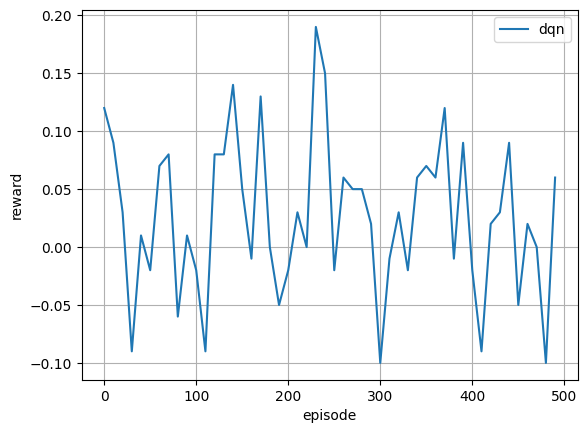

In [17]:
train()

In [18]:
env = rlcard.make('uno')
device = get_device()
dqn_agent = torch.load('uno/dqn_results/vs_Random_model.pth', map_location=device)
dqn_agent.set_device(device)
random_agent = RandomAgent(env.num_actions)
print(env.num_players)
env.set_agents([
    random_agent,
    dqn_agent
])

run_game(env)

--> Running on the CPU
2
>> UNO rule model V1
>> Start a new game

=============== Player 1 ===============
8, 9, 3, 2, 5, 8, Draw-2
=============== Table Card ===============
9
========== Players Card Number ===========
Player 2 has 7 cards.
======== Actions You Can Choose =========
0: 9, 1: Draw-2

>> Player 1 chooses 9

=============== Player 2 ===============
9, 6, Draw-2, 3, 5, 3, Skip
=============== Table Card ===============
9
========== Players Card Number ===========
Player 1 has 6 cards.
======== Actions You Can Choose =========
0: 9, 1: Draw-2, 2: Skip

>> Player 2 chooses 9

=============== Player 1 ===============
8, 3, 2, 5, 8, Draw-2
=============== Table Card ===============
9
========== Players Card Number ===========
Player 2 has 6 cards.
======== Actions You Can Choose =========
0: 8

>> Player 1 chooses 8

=============== Player 2 ===============
6, Draw-2, 3, 5, 3, Skip
=============== Table Card ===============
8
========== Players Card Number ===========
Player 